# An Introduction to PyTorch
In this notebook, we will get familiar with PyTorch, a powerful machine learning code base designed for neural networks and other machine learning applications.

**Learning Objectives**

1. Describe the PyTorch package and why it is faster than implementing models in NumPy from scratch.
2. Outline the components of a neural network implemented in PyTorch.
3. Implement a multi-layer perceptron in PyTorch.

**Import modules**

Begin by importing the modules to be used in this notebook.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import struct
import time

In [2]:
# modules from PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## What is PyTorch?

PyTorch is a machine learning framework that bundles up all of the calculus and linear algebra necessary to build and train neural networks behind the scenes, allowing the user to focus on the structure of the network. The calculations are done with PyTorch *tensors* which are similar to `numpy` arrays but designed to leverage the power of GPUs when present (although the functions also work on CPUs). When using PyTorch, we can check whether we have a GPU available on our machine and use this for calculations. Otherwise, we can just use CPUs:

In [3]:
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
print('Using device: '+device_name)
device = torch.device(device_name)

Using device: mps


With our device identified, we are ready to start some calculations. Just like with `numpy`, we can perform basic matrix calculations with PyTorch tensors. Let's check on the speed of these calculations using a matrix multiplication example. Begin by defining some random `numpy` arrays, and then an identical tensor in PyTorch:

In [4]:
# define a matrix size
n = 100

# define numpy matrices 
A = np.random.randn(n, n).astype(np.float32)
B = np.random.randn(n, n).astype(np.float32)

# define equivalent PyTorch tensors
A_tensor = torch.tensor(A, device=device).float()
B_tensor = torch.tensor(B, device=device).float()

# define the number of times to repeat the calculation
repeats = 100

With these matrices in hand, we can test the timing of matrix multiplication. First let's check with numpy:

In [5]:
# numpy check
C = A @ B # dummy calculation

start = time.perf_counter()
for _ in range(repeats):
    C = A @ B
end = time.perf_counter()

average_time = 1000*(end - start) / repeats
print('Average numpy matrix multiplication time: '+'{:.4f}'.format(average_time)+' ms')

Average numpy matrix multiplication time: 0.0244 ms


In [6]:
# tensor check
C_tensor = A_tensor @ B_tensor # dummy calculation

start = time.perf_counter()
for _ in range(repeats):
    C_tensor = A_tensor @ B_tensor
end = time.perf_counter()

average_time = 1000*(end - start) / repeats
print('Average tensor matrix multiplication time: '+'{:.4f}'.format(average_time)+' ms')

Average tensor matrix multiplication time: 0.0356 ms


Note: the time difference between these calculations will become apparent after running the calculation several times.

## The MNIST Dataset
In this notebook, we will again use the MNIST hand-drawn image data set as an example to test out models in PyTorch. Let's re-create the function to read in the data here:

In [7]:
def read_mnist_images(data_directory, subset='train'):
    if subset=='train':
        prefix = 'train-'
    else:
        prefix = 't10k-'
        
    with open(os.path.join('MNIST',prefix+'images.idx3-ubyte'), 'rb') as f:
        # unpack header
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        
        # read image data
        image_data = f.read(num_images * num_rows * num_cols)
        images = np.frombuffer(image_data, dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)

    with open(os.path.join('MNIST',prefix+'labels.idx1-ubyte'), 'rb') as f:
        # unpack header
        _, num_labels = struct.unpack('>II', f.read(8))

        # read label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)

        
    return images, labels

Next, let's read in the data and reshape into input arrays as in previous examples:

In [8]:
# load in the training and test images
train_images, train_labels = read_mnist_images('MNIST','train')
test_images, test_labels = read_mnist_images('MNIST','test')

# reshape as before
X_train = train_images.reshape(-1, 784) / 255.0
X_test = test_images.reshape(-1, 784) / 255.0
y_train = train_labels
y_test = test_labels

In this implementation, we have read in our data into `numpy` arrays. However, if we want to leverage the power of PyTorch, we'll need to change these arrays in PyTorch tensors. Let's do that here:

In [10]:
# create PyTorch tensor versions of the MNIST data
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

In addition, since we're going to implement our model with a one-hot encoding, let's leverage PyTorch's `one_hot` function to make equivalent arrays for our image labels:

In [11]:
# create one-hot encoded training label tensors
y_train_onehot = F.one_hot(y_train_tensor.to(torch.int64), num_classes=10).float()
y_test_onehot = F.one_hot(y_test_tensor.to(torch.int64), num_classes=10).float()

## The Single Layer Perception Revised: A PyTorch Implementation

In our previous lesson, we saw an implementation of the single layer perceptron with a single hidden layer that we wrote as follows: 

$$
\begin{align*}
z &= Xw^T+b \,\,\,&\text{   (Linear Layer)} \\ 
p &= \sigma(z)  \,\,\,&\text{   (Activation Function)}
\end{align*}
$$

Let's see how we implement this in PyTorch using a `SingleLayerPerceptron` class:

In [12]:
class SLP(nn.Module):

    # define an init function with a Linear layer
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    # implement the forward method
    def forward(self, x):
        out = torch.sigmoid(self.fc(x))
        return out

Here, we can see that we made a subclass of the `nn.Module` class - a highly flexible framework for building neural networks. We can also see that we've created our linear layer using the `nn.Linear` class and we've called the `sigmoid` function, which is already provided by PyTorch - convenient! These simple calls will handle all of the matrix multiplation behind the scenes, and we just need to provide the shapes of our data.

Once we have our class, we can make our model object, just like we've done with our previous classes. The only difference is that we implement the model with our computational resources in mind (GPU vs CPU):

In [13]:
# make an slp model object here
slp = SLP().to(device)

Ok, now that we have our model, how do we train it? If we take a look above, we see that we did NOT implement a backward method - that's a little curious given that we spent so much time last lesson computing gradients of the loss function to optimize the weights. We'll see why we didn't implement this shortly. First, let's define some important features that will be use to train our model.

#### The DataLoader

We'll start with the `TensorDataset` and the `DataLoader`:

In [21]:
# make a TensorDataset object for the training data
ds_train = TensorDataset(X_train_tensor, y_train_onehot)

# make a loader object for the training data
train_loader = DataLoader(ds_train, batch_size=64, shuffle=True)

In [22]:
# make a TensorDataset object for the test data
ds_test = TensorDataset(X_test_tensor, y_test_onehot)

# make a loader object for the test data
test_loader = DataLoader(ds_test, batch_size=64, shuffle=False)


These objects will allow us to efficiently train and use our model data. The `DataLoader` is a object that will provide subsets of our data from the dataset at a size given by `batch_size`. This will allow the model to be trained on mini-batches of data, rather than on the entire dataset at once.

#### The Loss Function
The definition of the loss function is key to the model training. Many of the common loss functions are are built into PyTorch (although you can also define your own loss function, if desired). Following the previous example, let's use the mean square error loss function here:

In [23]:
# define a criterion as the Mean Square Error Loss Function
criterion = nn.MSELoss()

This loss function will take in the output of the forward model as well as the training labels provided by the `DataLoader` above. Then, **the loss of the model computed from this function will be used by PyTorch to compute the gradients of the loss function with respect to the weights!** This is a key functionality of PyTorch!

#### Updating the Weights
To implement the update to the weights computed with the gradients of the loss function, we need to implement a gradient decent algorithm. Let's define that here:

In [24]:
# implement a gradient descent algorithm
optimizer = torch.optim.SGD(slp.parameters(), lr=0.5)

In the above code block, `SGD` stands for *Stochastic Gradient Descent* and it implements the gradient descent algorithm for us (i.e. it will update the weights in our model based on the gradients of our loss function). It is called *Stochastic* because the gradients are not computed on the entire dataset the way we implemented them in our previous perceptron example. Instead, the gradients are computed on a random sample of the data as determined by the `DataLoader`. The `SGD` algorithm is one possible gradient decesnt algorithm but we will see more examples in future applications.

### Putting it all together

Now that we've got our model, our loss function, and our gradient decent algorithm, we're ready to train our model. Just as before, let's run our forward, backward, and gradient decent algorithms, keeping track of the training and testing losses/accuracies as we go: 


In [25]:
# make empty arrays to store the losses for each epoch
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# loop through each epoch
for epoch in range(10):

    #- Testing Block --------------------------------
    slp.train()
    total_loss, correct, total = 0, 0, 0

    # loop through mini-batches in the data loader
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        # forward
        p = slp(x)
        
        # backward
        loss = criterion(p, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute the total loss
        total_loss += loss.item() * x.size(0)

        # predictions (argmax across 10 classes)
        pred = p.argmax(dim=1)
        true = y.argmax(dim=1)
        correct += (pred == true).sum().item() 
        total += x.size(0)

    train_loss = total_loss/total
    train_acc = correct/total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print(f"epoch {epoch+1}: loss={total_loss/total:.4f}, acc={correct/total:.3f}")

    # ---- Evaluation (Testing/Validation) ----
    slp.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            p = slp(x)
            loss = criterion(p, y)

            total_loss += loss.item() * x.size(0)

            pred = p.argmax(dim=1)
            true = y.argmax(dim=1)
            correct += (pred == true).sum().item() 
            total += x.size(0)

    test_loss = total_loss/total
    test_acc = correct/total
    test_losses.append(test_loss)
    test_accs.append(test_acc)

epoch 1: loss=0.0725, acc=0.665
epoch 2: loss=0.0465, acc=0.818
epoch 3: loss=0.0386, acc=0.850
epoch 4: loss=0.0345, acc=0.862
epoch 5: loss=0.0319, acc=0.867
epoch 6: loss=0.0301, acc=0.872
epoch 7: loss=0.0287, acc=0.876
epoch 8: loss=0.0276, acc=0.880
epoch 9: loss=0.0267, acc=0.883
epoch 10: loss=0.0260, acc=0.886


The model seems to be doing ok based on the reported losses. Let's have a look at the losses for the training and testing sets:

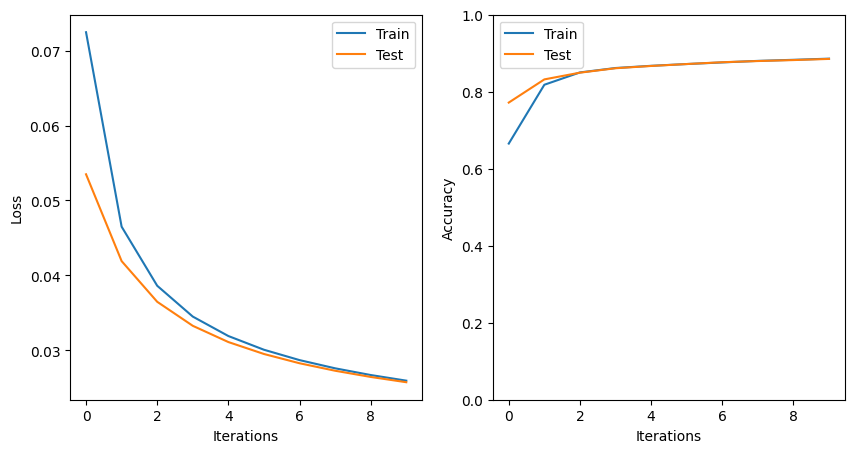

In [26]:
# plot the losses and accuracies
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(train_losses,label='Train')
plt.plot(test_losses,label='Test')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs,label='Train')
plt.plot(test_accs,label='Test')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xlabel('Iterations')
plt.show()

Let's see how our model does with the classification of our images

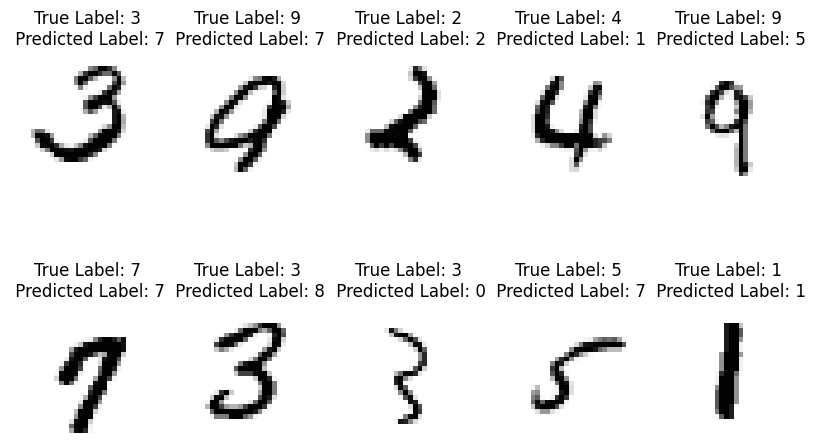

In [44]:
# choose some indices of the images to test
np.random.seed(37)
test_indices = np.random.randint(low=0, high=10000, size=10)

plt.figure(figsize=(10,6))
for d, index in enumerate(test_indices):

    # convert the image corresponding to this index to a tensor and predict
    # the label with the model
    input_tensor = torch.tensor(test_images[index,:, :].reshape(1, 784)).float().to(device)
    predicted_label = int(slp(input_tensor).argmax(dim=1)[0])
    with torch.no_grad():
        p = slp(input_tensor)
        predicted_label = p.argmax().item()

    # show the image with the predicted label
    plt.subplot(2,5,d+1)
    plt.imshow(train_images[index,:,:],cmap='Greys')
    plt.title('True Label: '+str(train_labels[index])+\
              '\n Predicted Label: '+str(predicted_label))
    plt.axis('off')

## Try it for yourself!

After implementing our single layer perceptron, we added a new layer to make our multilayer perceptron. We wrote this in equations as follows: 

$$
\begin{align*}
\zeta &= Xw_1^T+b_1 \,\,\,&\text{   (First Linear Layer)}\\ 
h &= \sigma(\zeta) \,\,\,&\text{   (First Activation Function)} \\ 
z &= hw_2^T+b_2 \,\,\,&\text{   (Second Linear Layer)} \\ 
p &= \sigma(z)  \,\,\,&\text{   (Second Activation Function)}
\end{align*}
$$

Following the structure above, implement a `MLP` class here. You should only need to make a few small additions to the `SLP` class above:

In [38]:
# implement an MLP class here
class MLP(nn.Module):

    def __init__(self, in_dim=784, hidden_dim=50, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        h = torch.sigmoid(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out

Next, create an object with your class:

In [39]:
# make an mlp object here
mlp = MLP().to(device)

Then, define a loss function and a gradient decent algorithm for your model:

In [40]:
# define the criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.5)

Now, your model is ready to train! Implement a training loop here:

In [41]:
# implement a training and testing loop here

# make empty arrays to store the losses for each epoch
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# loop through each epoch
for epoch in range(10):

    #- Testing Block --------------------------------
    mlp.train()
    total_loss, correct, total = 0, 0, 0

    # loop through mini-batches in the data loader
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # forward
        p = mlp(x)
        
        # backward
        loss = criterion(p, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute the total loss
        total_loss += loss.item() * x.size(0)
        # predictions (argmax across 10 classes)
        pred = p.argmax(dim=1)
        true = y.argmax(dim=1)
        correct += (pred == true).sum().item() 
        total += x.size(0)
        
    train_loss = total_loss/total
    train_acc = correct/total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"epoch {epoch+1}: loss={total_loss/total:.4f}, acc={correct/total:.3f}")
    # ---- Evaluation (Testing/Validation) ----
    mlp.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            p = mlp(x)
            loss = criterion(p, y)
            total_loss += loss.item() * x.size(0)
            pred = p.argmax(dim=1)
            true = y.argmax(dim=1)
            correct += (pred == true).sum().item() 
            total += x.size(0)
    test_loss = total_loss/total
    test_acc = correct/total
    test_losses.append(test_loss)
    test_accs.append(test_acc)

epoch 1: loss=0.0879, acc=0.295
epoch 2: loss=0.0671, acc=0.549
epoch 3: loss=0.0481, acc=0.746
epoch 4: loss=0.0370, acc=0.826
epoch 5: loss=0.0307, acc=0.857
epoch 6: loss=0.0268, acc=0.872
epoch 7: loss=0.0242, acc=0.881
epoch 8: loss=0.0223, acc=0.887
epoch 9: loss=0.0210, acc=0.891
epoch 10: loss=0.0199, acc=0.896


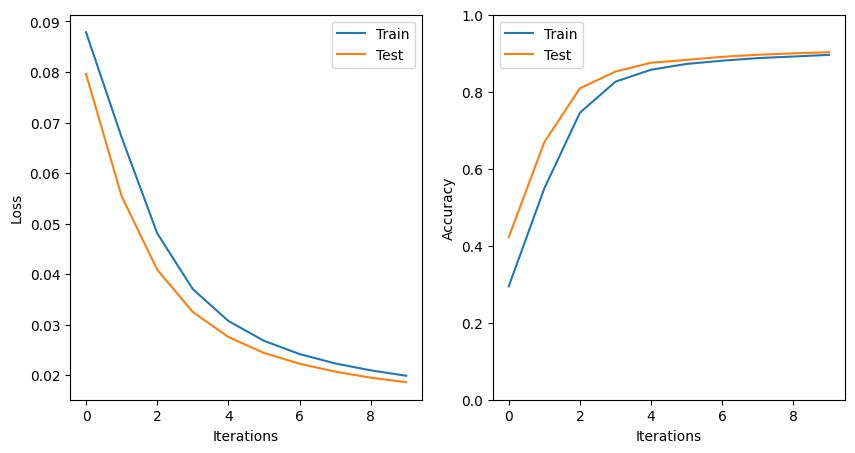

In [42]:
# plot the losses and accuracies
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(train_losses,label='Train')
plt.plot(test_losses,label='Test')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs,label='Train')
plt.plot(test_accs,label='Test')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xlabel('Iterations')
plt.show()

Compare and contrast the single and multi-layer models creaed above. Which is the "better" model?

The MLP model reached a peak accuracy of 89.6%, while the SLP model reached a peak accuracy of 88.6%. By this metric, the MLP model was slightly more accurate. It is also worth noting that the MLP model started at 29.5% accuracy after the first epoch, which was far worse than the SLP's 66.5% mark after one epoch. Despite starting so inaccurate, the MLP trained much better than the SLP.